In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN, KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

# Project Overview
This project focuses on clustering individuals based on their physical, dietary, and lifestyle attributes to determine obesity levels. It is an **unsupervised learning** problem, utilizing **DBSCAN** as the primary clustering method. The goal is to group individuals into clusters representing different obesity patterns and compare DBSCAN's performance with **KMeans** and **MiniBatchKMeans**. The dataset used is the Obesity Levels dataset, which includes synthetic and real data for predicting obesity categories.

## Motivation and Goal
Obesity is a leading global health issue, contributing to diseases like diabetes, heart conditions, and hypertension. Identifying patterns in obesity-related factors through clustering can help in preventive healthcare without relying on labeled data. This project aims to apply density-based clustering (DBSCAN) due to its ability to handle noise and arbitrary-shaped clusters, while comparing it to centroid-based methods (KMeans and MiniBatchKMeans) in terms of efficiency and quality. Performance is evaluated using internal metrics, such as the silhouette score, and external metrics, including the Adjusted Rand Index (ARI), against the provided labels for validation. The primary goal is to assess which method best captures underlying obesity groups, with a focus on interpretability and scalability.

## Data Description
We use the `ObesityDataSet_raw_and_data_sinthetic.csv` in [Estimation of Obesity Levels Based On Eating Habits and Physical Condition](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition) from the UCI Machine Learning Repository. The dataset combines raw and synthetic data on obesity factors. This dataset enables clustering based on attributes such as age, height, weight, eating habits, and physical activity to identify patterns related to obesity.

- **Number of samples/rows**: 2,111.
- **Number of features/columns**: 16.
- **Data types**: Mix of categorical (e.g., Gender, CAEC) and numeric (e.g., Age, Height, Weight).
- **Features**:
  - `Gender`: Male/Female (categorical).
  - `Age`: Age in years (continuous).
  - `Height`: Height in meters (continuous).
  - `Weight`: Weight in kg (continuous).
  - `family_history_with_overweight`: Family history of overweight (yes/no, binary).
  - `FAVC`: Frequent consumption of high-caloric food (yes/no, binary).
  - `FCVC`: Frequency of vegetable consumption (numeric, 1-3).
  - `NCP`: Number of main meals (numeric, 1-4).
  - `CAEC`: Consumption of food between meals (categorical: no, Sometimes, Frequently, Always).
  - `SMOKE`: Smoking habit (yes/no, binary).
  - `CH2O`: Daily water consumption (numeric, 1-3 liters).
  - `SCC`: Calories consumption monitoring (yes/no, binary).
  - `FAF`: Physical activity frequency (numeric, 0-3 days/week).
  - `TUE`: Time using technology devices (numeric, 0-2 hours/day).
  - `CALC`: Alcohol consumption (categorical: no, Sometimes, Frequently).
  - `MTRANS`: Transportation mode (categorical: Public_Transportation, Walking, Automobile, Motorbike, Bike).
- **Target** (for evaluation, not training): `NObeyesdad` (categorical: Insufficient_Weight, Normal_Weight, Overweight_Level_I/II, Obesity_Type_I/II/III; 7 classes).
- **File size**: Small (~250 KB).
- **Multi-table or sources**: Single table; combines raw and synthetic data.

GIT: https://github.com/Gear2382/Obesity-Clustering-Analysis

---

# Import the data
Load the data, and look at the first five rows:

In [ ]:
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


---

# Data Cleaning
## Identifying Missing Data
Although the webpage description states there is no missing data, it's still worth checking.

In [ ]:
print(df.dtypes)

Gender                             object
Age                               float64
Height                            float64
Weight                            float64
family_history_with_overweight     object
FAVC                               object
FCVC                              float64
NCP                               float64
CAEC                               object
SMOKE                              object
CH2O                              float64
SCC                                object
FAF                               float64
TUE                               float64
CALC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object


In [ ]:
print("Gender:", df['Gender'].unique())
print("family_history_with_overweight:", df['family_history_with_overweight'].unique())
print("FAVC:", df['FAVC'].unique())
print("CAEC:", df['CAEC'].unique())
print("SMOKE:", df['SMOKE'].unique())
print("SCC:", df['SCC'].unique())
print("CALC:", df['CALC'].unique())
print("MTRANS:", df['MTRANS'].unique())

Gender: ['Female' 'Male']
family_history_with_overweight: ['yes' 'no']
FAVC: ['no' 'yes']
CAEC: ['Sometimes' 'Frequently' 'Always' 'no']
SMOKE: ['no' 'yes']
SCC: ['no' 'yes']
CALC: ['no' 'Sometimes' 'Frequently' 'Always']
MTRANS: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']


---

# Exploratory Data Analysis (EDA)

**Distribution Plots**:
- **Age**: Concentrated around 20-30 years, with a long tail up to 61 (mean ~24). Suggests a younger population with some outliers.
- **Height**: Approximately normal, ranging 1.5-1.9m (mean ~1.65m), slight male/female differences (males taller on average).
- **Weight**: Wide range (40-150kg, mean ~80kg), reflecting diverse obesity levels. Notable peak around 110-120kg, likely Obesity_Type_III.
- **FCVC (Vegetable Consumption)**: Discrete (1-3), heavily skewed toward 3 (frequent consumption), indicating healthy eating habits in many samples.
- **NCP (Main Meals)**: Discrete (1-4), clustered around 3 meals/day, with some outliers at 1 or 4.
- **CH2O (Water Consumption)**: Bimodal, peaks around 2 and 3 liters, suggesting varied hydration habits.
- **FAF (Physical Activity)**: Many at 0-1 days/week, indicating low activity levels for most.
- **TUE (Technology Use)**: Concentrated at 0-1 hours/day, with a few heavy users.


**Description of Correlation Plot**:
- **Weight and Height**: Moderate positive correlation, expected as taller individuals may weigh more, but not perfectly linear due to obesity variations.
- **Weight and FCVC**: Weak negative correlation, suggesting higher vegetable consumption slightly associates with lower weight.
- **Weight and FAF**: Weak negative correlation, indicating more physical activity links to lower weight, aligning with clinical expectations.
- **Age and Weight**: Weak positive correlation, suggesting older individuals may have slightly higher weights.
- **Other correlations**: Low correlations (<0.2), indicating limited direct relationships among lifestyle factors.
- **No strong multicollinearity**: All correlations <0.7, suitable for clustering without feature redundancy.



(2111, 17)
               Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.586058     2.419043     2.685628   
std       6.345968     0.093305    26.191172     0.533927     0.778039   
min      14.000000     1.450000    39.000000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   173.000000     3.000000     4.000000   

              CH2O          FAF          TUE  
count  2111.000000  2111.000000  2111.000000  
mean      2.008011     1.010298     0.657866  
std       0.612953     0.850592     0.608927  
min       1.000000     0.000000     0.000000  
25%       1.584812     0.124505     0.000000  
50%       2.000000     1.000000     0.62

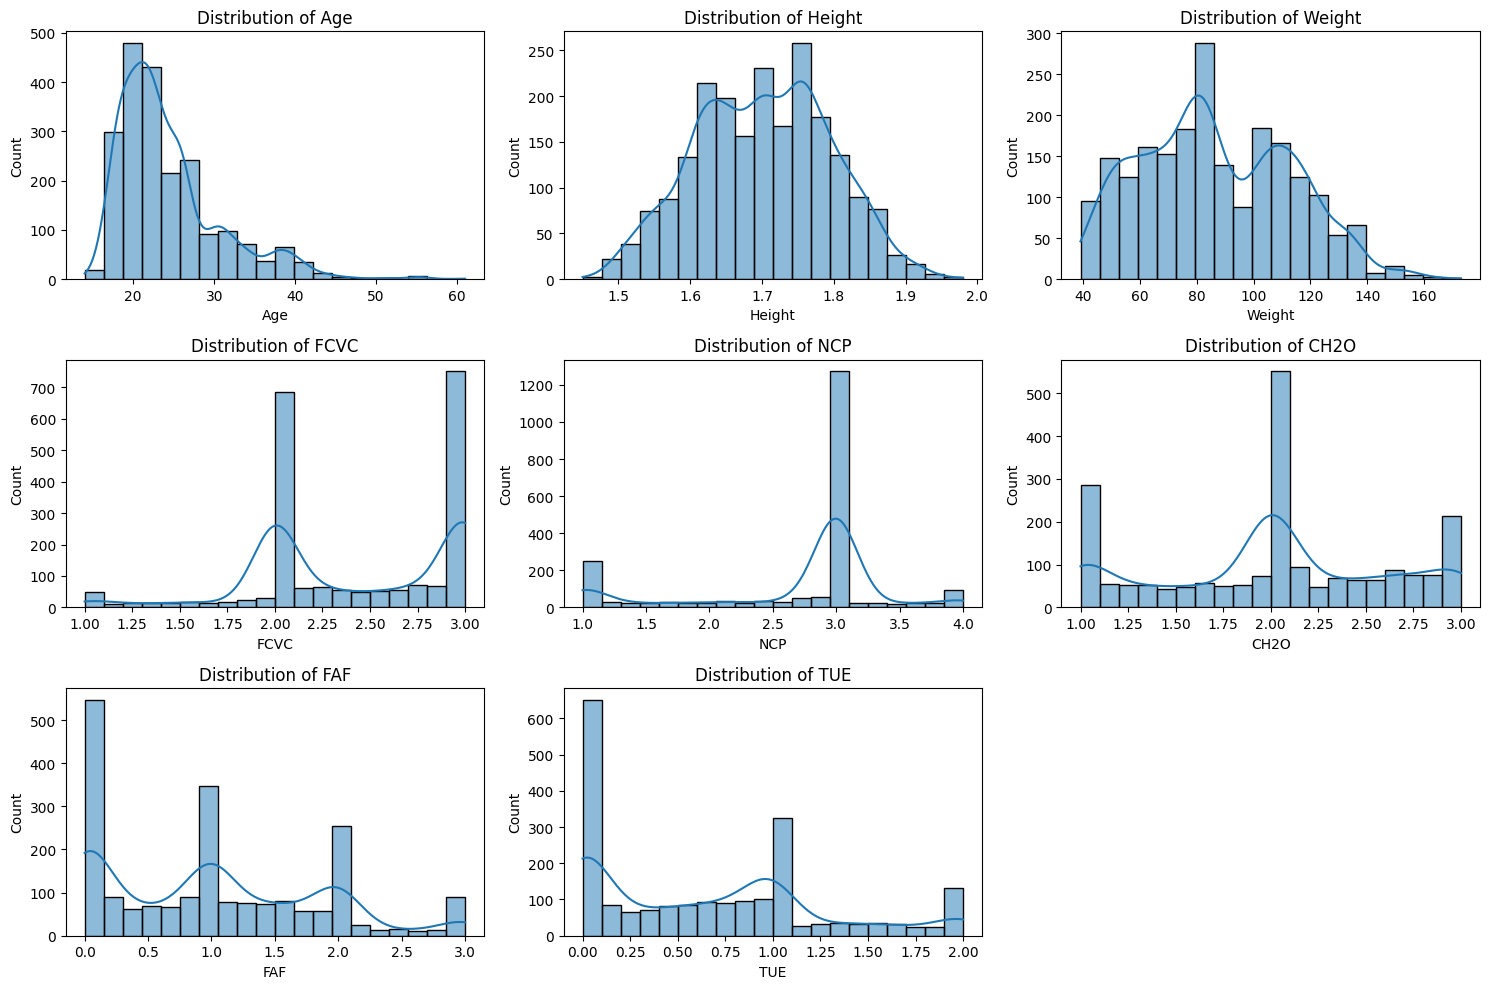

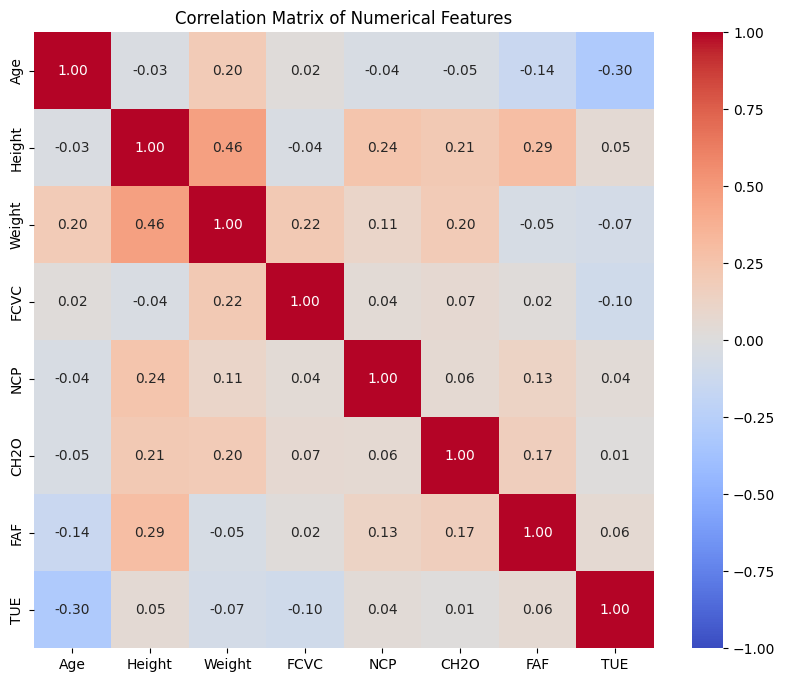

In [ ]:
# Data summary
print(df.shape)
print(df.describe())
print(df['NObeyesdad'].value_counts())

# Distribution plots for numerical features
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Correlation matrix for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

---

# Data Preprocessing
Handle categorical features with one-hot encoding and scale numerical features.

- **PCA Application**: `PCA(n_components=8)` reduces the dimensionality of the preprocessed data (e.g., from 23 features after one-hot encoding to 8 principal components). This was chosen to retain 88% of the variance, improving cluster separation for DBSCAN by reducing noise from high-dimensional categorical encodings.
- **Purpose**: Dimensionality reduction helps DBSCAN to focus on the most informative features, mitigating the curse of dimensionality, and enhancing density-based clustering performance.
- **Visualization**: The scatter plot of the first two principal components (PC1 vs. PC2) provides a 2D view of the data structure, aiding in understanding cluster potential before applying clustering algorithms.


Preprocessed shape: (2111, 23)
PCA shape: (2111, 8)
Explained variance ratio: 0.8842


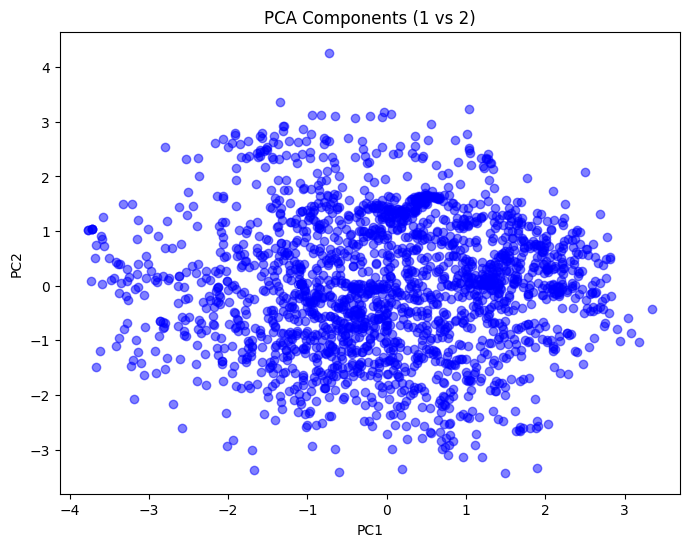

In [ ]:
# Define categorical and numerical columns
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

# Preprocessor for scaling numerical and encoding categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Features and target
X = df.drop('NObeyesdad', axis=1).copy()
y_true = df['NObeyesdad'].copy()  # For evaluation

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)
print(f"Preprocessed shape: {X_preprocessed.shape}")

# PCA for dimensionality reduction
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_preprocessed)
print(f"PCA shape: {X_pca.shape}")

# Explained variance ratio
print(f"Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")

# Visualize PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', alpha=0.5)
plt.title('PCA Components (1 vs 2)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

---

# Clustering Models
Apply DBSCAN (primary), KMeans, and MiniBatchKMeans.

## 1. DBSCAN (Primary Method with Grid Search)
Tune DBSCAN's hyperparameters (eps and min_samples) using grid search to maximize the silhouette score, ensuring optimal cluster formation.

In [ ]:
# Define parameter grid for DBSCAN
param_grid = {
    'eps': np.arange(0.5, 3.0, 0.5),    # Range of eps values
    'min_samples': np.arange(2, 10, 2)  # Range of min_samples
}

# Grid search for DBSCAN
best_sil = -1
best_params = {}
best_clusters = None

for params in ParameterGrid(param_grid):
    dbscan = DBSCAN(**params)
    clusters = dbscan.fit_predict(X_pca)
    if len(set(clusters)) > 1:  # Valid clusters
        sil = silhouette_score(X_pca, clusters)
        if sil > best_sil:
            best_sil = sil
            best_params = params
            best_clusters = clusters

# Best model
dbscan = DBSCAN(**best_params)
clusters_dbscan = dbscan.fit_predict(X_pca)
sil_dbscan = silhouette_score(X_pca, clusters_dbscan) if len(set(clusters_dbscan)) > 1 else -1
ari_dbscan = adjusted_rand_score(y_true, clusters_dbscan)
print(f"Best DBSCAN Params: {best_params}")
print(f"DBSCAN Silhouette: {sil_dbscan}, ARI: {ari_dbscan}")

Best DBSCAN Params: {'eps': np.float64(2.5), 'min_samples': np.int64(2)}
DBSCAN Silhouette: 0.37834007309176865, ARI: 3.144931466489803e-05


## 2. KMeans

Assume 7 clusters for the KMeans methods based on known labels.

In [ ]:
kmeans = KMeans(n_clusters=7, init='k-means++', n_init=20, random_state=42)
clusters_kmeans = kmeans.fit_predict(X_pca)

sil_kmeans = silhouette_score(X_pca, clusters_kmeans)
ari_kmeans = adjusted_rand_score(y_true, clusters_kmeans)
print(f"KMeans Silhouette: {sil_kmeans}, ARI: {ari_kmeans}")

KMeans Silhouette: 0.17512218051312456, ARI: 0.2560792250921055


## 3. MiniBatchKMeans

Similar to KMeans but faster for large data.


In [ ]:
minibatch = MiniBatchKMeans(n_clusters=7, batch_size=200, n_init=20, random_state=42)
clusters_minibatch = minibatch.fit_predict(X_pca)

sil_minibatch = silhouette_score(X_pca, clusters_minibatch)
ari_minibatch = adjusted_rand_score(y_true, clusters_minibatch)
print(f"MiniBatchKMeans Silhouette: {sil_minibatch}, ARI: {ari_minibatch}")

MiniBatchKMeans Silhouette: 0.16969566151547322, ARI: 0.2714946981868492


---

# Results and Analysis


| Method | Silhouette Score | ARI Score |
|---|:---:|:---:|
| DBSCAN (Primary) | 0.378 | 3.14e-05 |
| KMeans | 0.175 | 0.256 |
| MiniBatchKMeans | 0.170 | 0.271 |
<br>

- **Why KMeans/MiniBatchKMeans Outperform in ARI**:
KMeans and MiniBatchKMeans outperformed DBSCAN in ARI (0.256 and 0.271 vs. 3.14e-05), likely because their centroid-based approach better aligns with the dataset's underlying structure when forced to form seven clusters (matching the number of `NObeyesdad` categories). The dataset's features, after PCA reduction to 8 components, may have retained sufficient linear separability, allowing KMeans methods to capture patterns closer to the actual labels. MiniBatchKMeans slightly outperformed KMeans in ARI, possibly due to its robustness to noise in the larger dataset (2,111 samples) through mini-batch updates, though both methods suffered from lower silhouette scores, indicating less cohesive clusters compared to DBSCAN.

- **Why DBSCAN Underperforms in ARI Despite High Silhouette**:
DBSCAN's high silhouette score (0.378) reflects its ability to form dense, well-separated clusters with the tuned parameters (eps = 2.5, min_samples = 2). However, its near-zero ARI (3.14e-05) indicates a significant mismatch with the true obesity categories. This discrepancy suggests that DBSCAN's density-based clusters do not correspond to the predefined `NObeyesdad` labels, possibly due to the dataset's complex, non-uniform distributions (e.g., skewed Weight and Obesity_Type_III dominance). DBSCAN's sensitivity to parameter settings and its tendency to mark outliers as noise may have resulted in clusters that capture local density patterns but fail to align with the broader categorical structure. The low min_samples may also have caused overfitting to small, dense regions, further misaligning with proper labels.
---

# Discussion and Conclusion

**Learnings and Takeaways**:
The analysis revealed distinct patterns in obesity-related factors such as Weight, Height, and dietary habits (FCVC, NCP). DBSCAN achieved the highest silhouette score (0.378), indicating strong cluster cohesion. However, its extremely low ARI (3.14e-05) suggests poor alignment with the true obesity categories. Conversely, KMeans (silhouette: 0.175, ARI: 0.256) and MiniBatchKMeans (silhouette: 0.170, ARI: 0.271) showed better alignment with ground-truth labels but lower cluster quality. These results highlight the trade-offs between density-based and centroid-based clustering approaches for this dataset.

## Suggestion:
- **Refine DBSCAN Parameters**: Increase `min_samples` (e.g., 5-10) to reduce overfitting to small clusters and test a wider `eps` range (1.0-5.0) to capture global density patterns better, potentially improving ARI.
- **Feature Engineering**: Incorporate derived features like BMI (Weight/Height²) to enhance cluster relevance to obesity categories, as raw Weight and Height may not fully capture obesity dynamics.
- **Hybrid Clustering**: Combine DBSCAN's density-based strengths with KMeans' centroid-based alignment using ensemble methods or hierarchical clustering to balance silhouette and ARI.
- **Alternative Dimensionality Reduction**: Explore t-SNE or UMAP instead of PCA to preserve non-linear structures, potentially improving DBSCAN's alignment with proper labels.
- **Larger Validation**: Use cross-validation or subsampling to ensure robustness across dataset variations, especially given the synthetic data component.

## Conclusion
DBSCAN excels in forming cohesive clusters (silhouette: 0.378) but fails to align with true obesity categories (ARI: 3.14e-05), making it less suitable for this dataset when label alignment is critical. KMeans and MiniBatchKMeans, while producing less cohesive clusters (silhouette: ~0.17), better capture the actual category structure (ARI: ~0.26-0.27), with MiniBatchKMeans slightly outperforming due to its scalability. This suggests that centroid-based methods are more effective for this dataset's structure, particularly after PCA reduction. Future work should focus on hybrid approaches or alternative dimensionality reduction methods to combine the cluster quality of DBSCAN with the label alignment of KMeans for improved detection of obesity patterns.